# IIIB: Bayesian Priors

In [1]:
import importlib
import os
import numpy as np
import pytomography
from misc import get_organ_masks, get_organ_volume, get_photopeak_scatter
import torch
import recon_script
importlib.reload(recon_script)
from scipy.ndimage import rotate
import sys
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LinearSegmentedColormap
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from pytomography.priors import RelativeDifferencePrior, AnatomyNeighbourWeight, TopNAnatomyNeighbourWeight
from pytomography.io.SPECT import simind
from pytomography.algorithms import OSEM, BSREM, KEM
import pickle
pytomography.device = device
colors = np.loadtxt('pet_colors.txt').reshape(-1,3)/255.0
custom_cmap = LinearSegmentedColormap.from_list('custom_colormap', colors)
from skimage import io, color

/tmp/ipykernel_5833/2814514513.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


Change this to where data is downloaded from

In [2]:
datapath = '/disk1/pytomography_paper_data/'

Change this to where you'd like to save output files

In [3]:
savepath = '/disk1/pytomography_paper_results/IIIB'

Types of reconstructions to be done

In [5]:
organ_specifications_path = os.path.join(datapath, 'simind', 'organ_specifications.csv')
organ_concentrations_path = os.path.join(datapath, 'simind', 'organ_concentrations.csv')
organ_concentrations_indices = [5]
recon_types = ['regular']
scatter_types = ['TEW']
algorithms = [OSEM, BSREM, KEM]
algorithm_kwargss = [{}, {'relaxation_function': lambda n: 1}, {}]
organ_segmentation_type = 'GT'
projection_times = [15]
random_seeds = [1,2,3,4,5]
CPSperMBq = 11.7284
n_iters = 120 

In [5]:
masks = get_organ_masks(organ_specifications_path, scale=False).cpu().numpy()
activities_true =  np.genfromtxt(organ_concentrations_path, delimiter=',').T[organ_concentrations_indices[0]+1]
GT = (masks*activities_true.reshape((-1,1,1,1))).sum(axis=0)
activities_true = np.array([np.mean(GT[mask>0]) for mask in masks.astype(int)])

In [6]:
_, _, GT_paths, projection_folders, regions = np.genfromtxt(organ_specifications_path, delimiter=',', skip_header=3, dtype=str).T

Open up 
* Object meta for reconstruction
* Masks/mask volumes needed to get activities in the callback

In [7]:
object_meta, _, _, _ = get_photopeak_scatter(organ_specifications_path, organ_concentrations_path, 0, dT=1, headerfile_peak='photopeak.h00', headerfile_lower='lowerscatter.h00', headerfile_upper='upperscatter.h00')
masks = get_organ_masks(organ_specifications_path, object_meta, full_voxel=False)
_, _, GT_paths, _, _ = np.genfromtxt(organ_specifications_path, delimiter=',', skip_header=3, dtype=str).T
GT_dz, GT_dy, GT_dx = np.genfromtxt(organ_specifications_path, delimiter=',', skip_header=1, max_rows=1).T
mask_volumes = np.vectorize(get_organ_volume)(GT_paths, GT_dx*GT_dy*GT_dz)

Run all reconstructions and save the data

In [8]:
for organ_concentrations_index in organ_concentrations_indices:
    for algorithm, algorithm_kwargs in zip(algorithms, algorithm_kwargss):
        for scatter_type in scatter_types:
            for projection_time in projection_times:
                for random_seed in random_seeds:
                        save_path = os.path.join(savepath, f'{organ_concentrations_path.split("/")[-1][:-4]}_{organ_concentrations_index}_recon{algorithm.__name__}_scat{scatter_type}_dT{projection_time}_masks{organ_segmentation_type}_niters{n_iters}_seed{random_seed}')
                        recon_script.reconstruct_phantom(organ_specifications_path, organ_concentrations_path, organ_concentrations_index, scatter_type, projection_time, CPSperMBq, n_iters, save_path, algorithm, algorithm_kwargs, masks=masks, mask_volumes=mask_volumes, save_recon_object=True, activities_true = activities_true, random_seed=random_seed)

/data/anaconda/envs/pytomographytest/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


# Plotting

Open all saved data from cells above

In [6]:
masks = get_organ_masks(organ_specifications_path, scale=False).cpu().numpy()
activities_true =  np.genfromtxt(organ_concentrations_path, delimiter=',').T[organ_concentrations_indices[0]+1]
GT = (masks*activities_true.reshape((-1,1,1,1))).sum(axis=0)
activities_true = np.array([np.mean(GT[mask>0]) for mask in masks.astype(int)])

In [7]:
test_osems = [np.load(os.path.join(savepath, f'organ_concentrations_5_reconOSEM_scatTEW_dT15_masksGT_niters120_seed{seed}_object.npy')) for seed in random_seeds]
test_kems = [np.load(os.path.join(savepath, f'organ_concentrations_5_reconKEM_scatTEW_dT15_masksGT_niters120_seed{seed}_object.npy')) for seed in random_seeds]
test_bsrems = [np.load(os.path.join(savepath, f'organ_concentrations_5_reconBSREM_scatTEW_dT15_masksGT_niters120_seed{seed}_object.npy')) for seed in random_seeds]
test_osem_statss = [np.load(os.path.join(savepath, f'organ_concentrations_5_reconOSEM_scatTEW_dT15_masksGT_niters120_seed{seed}.npz')) for seed in random_seeds]
test_kem_statss = [np.load(os.path.join(savepath, f'organ_concentrations_5_reconKEM_scatTEW_dT15_masksGT_niters120_seed{seed}.npz')) for seed in random_seeds]
test_bsrem_statss = [np.load(os.path.join(savepath, f'organ_concentrations_5_reconBSREM_scatTEW_dT15_masksGT_niters120_seed{seed}.npz')) for seed in random_seeds]

In [41]:
def get_ensemble_stats(statss):
    labels = statss[0]['labels']
    RCs = []
    for stats in statss:
        RCs.append(stats['activity_concs_pct'])
    RCs = np.array(RCs)
    return {'labels': labels, 'RCs': np.mean(RCs, axis=0), 'RCs_err': np.std(RCs, axis=0)}
def get_time_err(statss):
    times = []
    for stats in statss:
        times.append(stats['time_elapsed'])
    times = np.array(times)
    print(f'{np.mean(times)} and {np.std(times)}')
test_osem_stats = get_ensemble_stats(test_osem_statss)
test_bsrem_stats = get_ensemble_stats(test_bsrem_statss)
test_kem_stats = get_ensemble_stats(test_kem_statss)

In [48]:
get_time_err(test_kem_statss)

601.8030039787293 and 1.2523751093311493


In [49]:
601.8 / 120

5.015

Plot noise bias curves

In [30]:
def plot_bvc(stats, organ, ax, color, label, iter_n=None):
    idx = np.argmax(stats['labels']==organ)
    RCs = stats['RCs'][idx]
    RCs_err = stats['RCs_err'][idx]
    iters = np.arange(len(RCs))+1
    #ax.plot(iters, RCs, markersize=4, lw=1, color=color, label=label)
    ax.fill_between(iters, RCs-RCs_err, RCs+RCs_err, color=color, alpha=1, label=label)


def plot_object(ob, ax, mode='color', vmax_set=None, cmap_pet=False, idx=80):
    if mode=='color':
        tcol = 'white'
        cmap = 'nipy_spectral'
        vmax = 1
    elif mode=='bw':
        tcol = 'red'
        cmap = 'Greys'
        vmax = 0.4
    if cmap_pet:
        cmap = custom_cmap
    if vmax_set is not None:
        vmax=vmax_set
    im = ax.pcolormesh(ob[:,idx].T, cmap=cmap, vmax=vmax)
    #ax.axis('off')
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    return im

organs_ = ['l_lung', 'liver', 'r_kidney', 'l_kidney', 'salivary', 'bladder']
title_dict = {'l_lung': 'Lungs', 'liver': 'Liver', 'r_kidney': 'Right Kidney', 'l_kidney': 'Left Kidney', 'salivary': 'Salivary Glands', 'bladder': 'Bladder'}

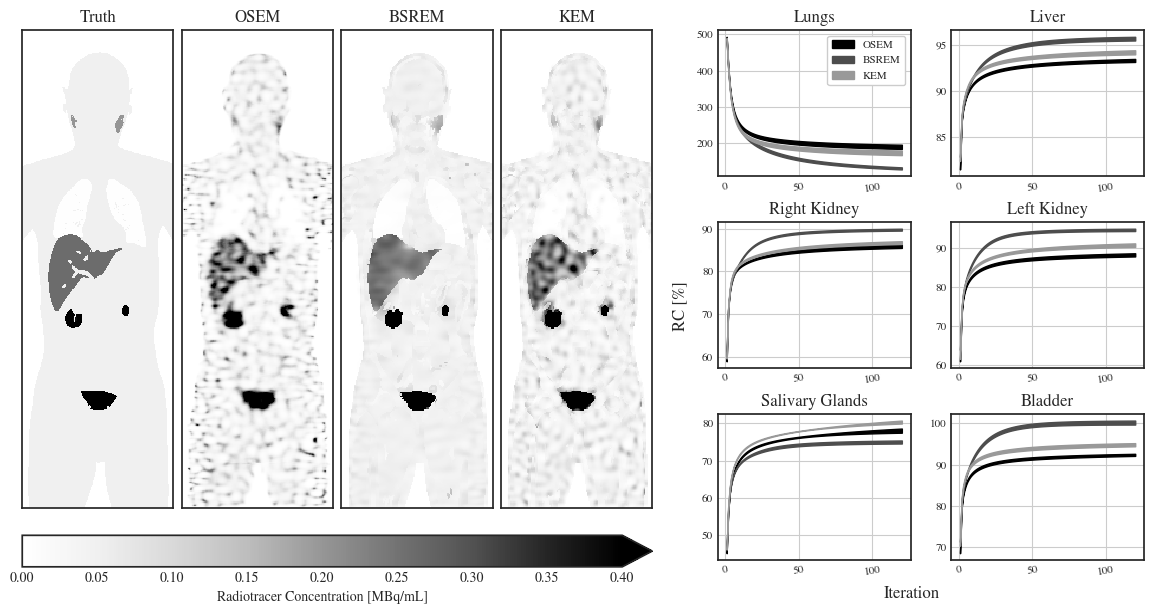

In [54]:
mode = 'bw'
idx = 64
fig = plt.figure(constrained_layout=True, figsize=(11.5,6))
(subfig_l, subfig_r) = fig.subfigures(nrows=1, ncols=2, width_ratios=(0.8,0.6))
axes_l = subfig_l.subplots(nrows=1, ncols=4)
axes_l[0].set_title('Truth')
axes_l[1].set_title('OSEM')
axes_l[2].set_title('BSREM')
axes_l[3].set_title('KEM')
plot_object(GT, axes_l[0], mode=mode, idx=4*idx)
im = plot_object(test_osems[0], axes_l[1], mode=mode, idx=idx)
plot_object(test_bsrems[0], axes_l[2], mode=mode, idx=idx)
plot_object(test_kems[0], axes_l[3], mode=mode, idx=idx)
subfig_l.colorbar(im, ax=axes_l, location='bottom', label='Radiotracer Concentration [MBq/mL]', extend='max')

#Noise bias curves
axes_r = subfig_r.subplots(nrows=3, ncols=2)
for ax, organ in zip(axes_r.ravel(), organs_):
    plot_bvc(test_osem_stats, organ, ax, '0', 'OSEM', iter_n=7)
    plot_bvc(test_bsrem_stats, organ, ax, '0.3', 'BSREM', iter_n=-1)
    plot_bvc(test_kem_stats, organ, ax, '0.6', 'KEM', iter_n=-1)
    ax.grid()
    ax.tick_params(axis='y', which='major', labelsize=8)
    ax.tick_params(axis='x', which='major', labelsize=8, rotation=10)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.set_title(title_dict[organ])
axes_r[0,0].legend(facecolor='white', framealpha=1, frameon=True, loc='upper right', fontsize=8)
subfig_r.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
subfig_r.supylabel('RC [%]')
subfig_r.supxlabel('Iteration')

plt.savefig('images/figure3.jpg', bbox_inches='tight', dpi=300)